In [1]:
! pip install --quiet cohere git+https://github.com/richardmillson/toponymy.git@richardmillson/fix
# ! pip install --quiet cohere git+https://github.com/TutteInstitute/toponymy.git

In [2]:
import io
import zipfile
from pathlib import Path

import cohere
import datamapplot
import datamapplot.selection_handlers
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns
import umap
import vectorizers
import vectorizers.transformers
from matplotlib.colors import rgb2hex
from toponymy import Toponymy
from toponymy.llm_wrappers import CohereWrapper
from tokenizers import Tokenizer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /work/home/rtmills/.config/sagemaker/config.yaml


## Load Data

In [3]:
# Data URL from https://www.cs.cornell.edu/~arb/data/cat-edge-Cooking/
url = "https://drive.google.com/uc?export=download&id=16BTDEv3AC9l81FeU2US5nG30_CGsRTqk"
response = requests.get(url)
zip_file = io.BytesIO(response.content)
with zipfile.ZipFile(zip_file) as zf:
    print(zf.namelist())
    files = {name: zf.read(name) for name in zf.namelist()}

['cat-edge-Cooking/', 'cat-edge-Cooking/hyperedges.txt', 'cat-edge-Cooking/hyperedge-labels.txt', 'cat-edge-Cooking/hyperedge-label-identities.txt', 'cat-edge-Cooking/node-labels.txt', 'cat-edge-Cooking/README.txt']


Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-00-data-setup.ipynb .

In [4]:
ingredients_id = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/node-labels.txt"]), sep="\t", header=None)
ingredients_id.index = [x+1 for x in ingredients_id.index]
ingredients_id.columns = ["ingredient"]

In [5]:
recipes_with_id = [[int(ingredient) for ingredient in recipe.split("\t")] for recipe in
 files["cat-edge-Cooking/hyperedges.txt"].decode("utf8").strip().split("\n")]

In [6]:
recipes_all = [[ingredients_id.loc[int(i)]["ingredient"] for i in x] for x in recipes_with_id]

In [7]:
recipe_min_size = 3
recipes = [recipe for recipe in recipes_all if len(recipe) > recipe_min_size]

In [8]:
keep_recipes = np.array([len(recipe) > recipe_min_size for recipe in recipes_all])

In [9]:
recipes_label_id_all = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-labels.txt"]), sep="\t", header=None)
recipes_label_id_all.columns = ["label"]
recipes_label_id = recipes_label_id_all.iloc[keep_recipes].reset_index()

In [10]:
label_name = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-label-identities.txt"]), sep="\t", header=None)
label_name.columns = ["country"]
label_name.index = [x+1 for x in label_name.index]

In [11]:
recipes_country = [label_name.loc[i]["country"] for i in recipes_label_id.label] 

In [12]:
recipe_metadata = pd.DataFrame()
recipe_metadata["country"] = recipes_country
recipe_metadata["ingredients"] = recipes
recipe_metadata["recipe_size"] = [len(x) for x in recipes]

In [13]:
region_to_countries_map = {
    "Asian" : ("chinese", "filipino", "japanese","korean", "thai", "vietnamese"),
    "American" : ("brazilian", "mexican", "southern_us"),
    "British Isles" : ("british", "irish"),
    "Caribbean" : ("cajun_creole", "jamaican"),
    "European" : ("french", "italian", "spanish", "greek", "russian"),
    "Unlabelled" : ("indian", "moroccan")
}

In [14]:
country_to_region_map = {country: region for region, countries in region_to_countries_map.items() for country in countries}

In [15]:
recipe_metadata["region"] = recipe_metadata["country"].map(country_to_region_map)

## Cooccurrence Embedding

Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-03-joint-annotated.ipynb .

In [ ]:
vectorizer = vectorizers.NgramVectorizer(ngram_size=3, ngram_behaviour="subgrams").fit(ca_domains)
matrix = vectorizer.transform(ca_domains)

matrix_info_weighted = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(matrix)

embedding = umap.UMAP(
    metric="cosine", n_components=2,
).fit(matrix_info_weighted)

doc_matrix = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit_transform(recipes)

In [ ]:
vectorizer = vectorizers.TokenCooccurrenceVectorizer().fit(recipes)
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=vectorizer.token_label_dictionary_
).fit(recipes)

In [17]:
def vertexCooccurrenceVectorizer(hyperedges):
    vertexCooccurrence_vectorizer = vectorizers.TokenCooccurrenceVectorizer().fit(hyperedges)
    
    incidence_vectorizer = vectorizers.NgramVectorizer(
        token_dictionary=vertexCooccurrence_vectorizer.token_label_dictionary_
    ).fit(hyperedges)

    H = incidence_vectorizer.transform(hyperedges)
    
    M_cooccurrence = (H.T@H)
    M_cooccurrence.setdiag(0)
    M_cooccurrence.eliminate_zeros()
    
    vertexCooccurrence_vectorizer.cooccurrences_ = M_cooccurrence
    
    return(vertexCooccurrence_vectorizer)

In [ ]:
ingredient_vectorizer = vertexCooccurrenceVectorizer(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")
n_ingredients = len(ingredient_vectorizer.token_index_dictionary_)
ingredients = [ingredient_vectorizer.token_index_dictionary_[i] for i in range(n_ingredients)]

In [19]:
ingredient_metadata = pd.DataFrame({"ingredients": [[x] for x in ingredients], "country": "Unlabelled", "region": "Unlabelled", "recipe_size": 1})

df = pd.concat([recipe_metadata, ingredient_metadata], axis=0)

n_recipes = len(recipes)

is_ingredient = np.hstack([np.zeros(n_recipes),
                           np.ones(n_ingredients)]).astype(bool)

df["is_ingredient"] = is_ingredient

In [20]:
df["country"] = df["country"].str.replace("_", " ").str.title()

In [21]:
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit(recipes)

incidence_matrix = incidence_vectorizer.transform(recipes)

In [22]:
info_weighted_incidence = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(incidence_matrix)

In [23]:
info_doc_with_identity = scipy.sparse.vstack([info_weighted_incidence, scipy.sparse.identity(n_ingredients)])

In [24]:
joint_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.25,
    random_state=42,
).fit_transform(info_doc_with_identity, vectors=ingredient_vectors)

In [ ]:
joint_vectors_mapper = umap.UMAP(metric="cosine", random_state=42).fit(joint_vectors_unsupervised)

In [26]:
df["x"] = joint_vectors_mapper.embedding_[:, 0]
df["y"] = joint_vectors_mapper.embedding_[:, 1]

## Cohere Embedding

Embed each recipe using Cohere's API.

In [3]:
class CohereEmbed:
    """Wrap the Cohere API to make it more closely align with
    sentence_transformers.SentenceTransformer.
    """

    def __init__(
        self,
        llm: cohere.client.Client,
        model: str = "embed-english-light-v3.0",
    ):
        self.llm = llm
        self.model = model

    def encode(self, texts, show_progress_bar=None):
        """
        Ignore show_progress_bar which isn"t supported by the Cohere API but
        expected by code written for sentence_transformers.SentenceTransformer.
        """
        response = self.llm.embed(
            texts=texts,
            model=self.model,
            input_type="clustering",
        )
        return response.embeddings

In [6]:
llm = CohereWrapper(API_KEY)

In [7]:
embedding_model = CohereEmbed(llm.llm)

In [74]:
# TODO: Does sorting (or randomly permuting) the ingredients have a large impact on the embedding?
# df.loc[~df["is_ingredient"], "ingredients"].apply(sorted).map(", ".join)

Ensure the recipes are within the embed model's context length, and that it's ok to extend them with a template.

In [28]:
# https://docs.cohere.com/v2/docs/tokens-and-tokenizers#tokenization-in-python-sdk
tokenizer_url = embedding_model.llm.models.get(embedding_model.model).tokenizer_url
response = requests.get(tokenizer_url)  
tokenizer = Tokenizer.from_str(response.text)

In [54]:
tokens = tokenizer.encode_batch(input=df["ingredients"].map(", ".join), add_special_tokens=False)

In [29]:
context_length = embedding_model.llm.models.get(embedding_model.model).context_length

In [66]:
sum([len(encoding.tokens) > context_length for encoding in tokens]) / len(tokens)

0.0

In [69]:
recipe_template = "a recipe specified by the ingredients: {}"
prompts = [recipe_template.format(recipe) for recipe in df.loc[~df["is_ingredient"], "ingredients"].map(", ".join)]

In [71]:
ingredient_template = "the ingredient: {}"
prompts += [ingredient_template.format(ingredient) for ingredient in df.loc[df["is_ingredient"], "ingredients"].map(lambda x: x[0])]

In [154]:
embeddings = embedding_model.encode(prompts)

In [159]:
df["prompts"] = prompts

In [160]:
df["vectors_llm"] = embeddings

In [40]:
df.to_parquet(Path("../data/recipes.parquet"))

## Topic Naming

In [8]:
df = pd.read_parquet(Path("../data/recipes.parquet"))

In [10]:
topic_namer = Toponymy(
    documents=df.loc[~df["is_ingredient"], "ingredients"].map(", ".join),
    document_vectors=np.array(df.loc[~df["is_ingredient"], "vectors_llm"].to_list()),
    document_map=df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    llm=llm,
    embedding_model=embedding_model,
    document_type="recipes as list of ingredients",
    corpus_description="recipes",
    verbose=True,
)

In [ ]:
topic_namer.fit_clusters(base_min_cluster_size=500)

In [12]:
topic_namer.fit_representation()

Topical sentences for layer 0:   0%|          | 0/20 [00:00<?, ?it/s]

Topical sentences for layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Finding contrastive keywords:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
topic_namer.clean_topic_names()

Generating base layer prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating topics for layer 0:   0%|          | 0/20 [00:00<?, ?it/s]

Distance threshold 0.7037079395668712
Cluster sizes [7 5 8]


Distinguishing similar topics:   0%|          | 0/3 [00:00<?, ?it/s]

Finding topical subtopics:   0%|          | 0/1 [00:00<?, ?it/s]

Generating prompts for layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating topics for layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Distinguishing similar topics in layer 1:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaning layer topic names for layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Cleaning layer topic names for layer 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
pd.Series(topic_namer.layer_clusters[0]).value_counts()

Unlabelled                                              17776
Sweet & Savory Bakes: From Cakes to Pastries             5907
Thai Street Food: Noodles, Salads & More                 1377
Cajun-Creole Rice and Seafood Feasts                     1372
Traditional Indian Curries: A Flavourful Journey         1137
Southern Comfort Seafood and Sides                       1036
Hearty Beef Stews: Comforting Dishes for All Seasons      981
Italian Pasta Classics                                    881
Spicy Indian Delights: Fiery & Fragrant Curries           858
Soy-Ginger-Sesame Asian Dishes                            836
Cumin-Chili Mexican Inspired Dishes                       703
Beef and Sausage Lasagna Dishes                           697
Mediterranean Seafood Delights                            694
Tasty Mexican Tortillas: A Fiesta of Flavours             676
Ginger-Soy Asian Chicken Dishes                           636
Tasty Taco & Burrito Creations: A Mexican Delight         634
Greek Yo

In [29]:
pd.Series(topic_namer.layer_clusters[1]).value_counts()

Unlabelled                   12969
Global Gourmet Meals         10791
Tasty Mexican Treats          5615
Spicy Indian Curries          3489
Southern Seafood Feasts       3186
Soy-Ginger Asian Delights     2960
Name: count, dtype: int64

In [38]:
for i, layer in enumerate(topic_namer.layer_clusters):
    df.loc[~df["is_ingredient"], f"topic_names_layer_{i}"] = layer

## Data Map

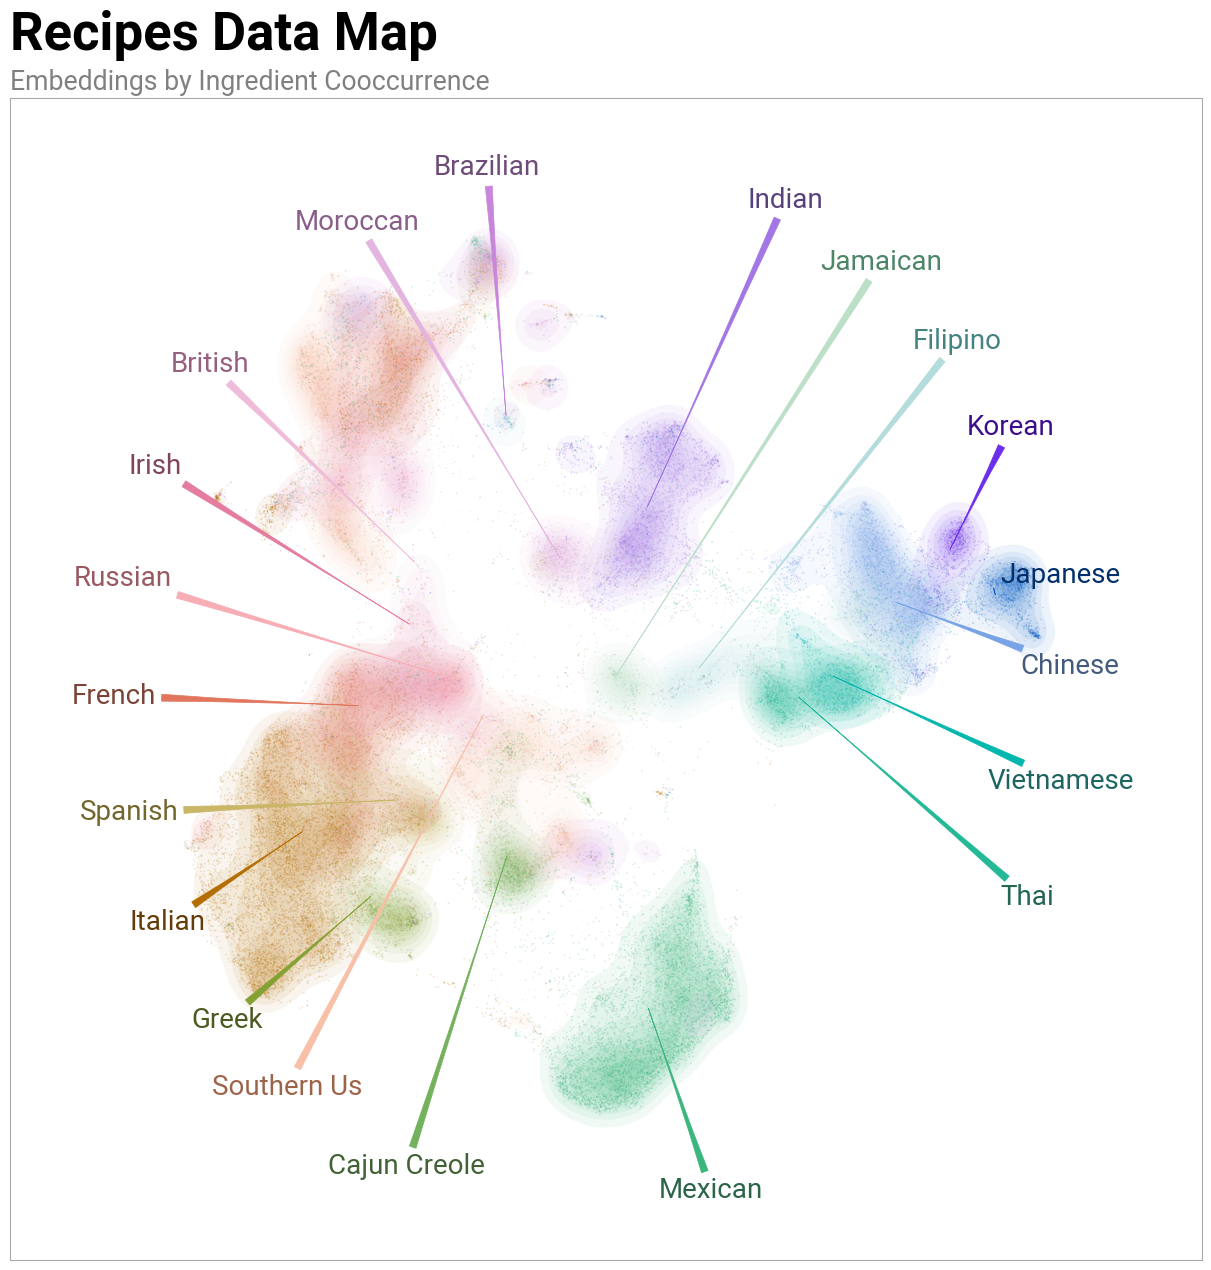

In [77]:
fig, ax = datamapplot.create_plot(
    df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["is_ingredient"], "country"],
    title="Recipes Data Map",
    sub_title="Embeddings by Ingredient Cooccurrence",
    label_font_size=20,
    use_medoids=True,
    color_label_arrows=True, 
    arrowprops={"arrowstyle": "wedge, tail_width=0.25, shrink_factor=0.25"},
)

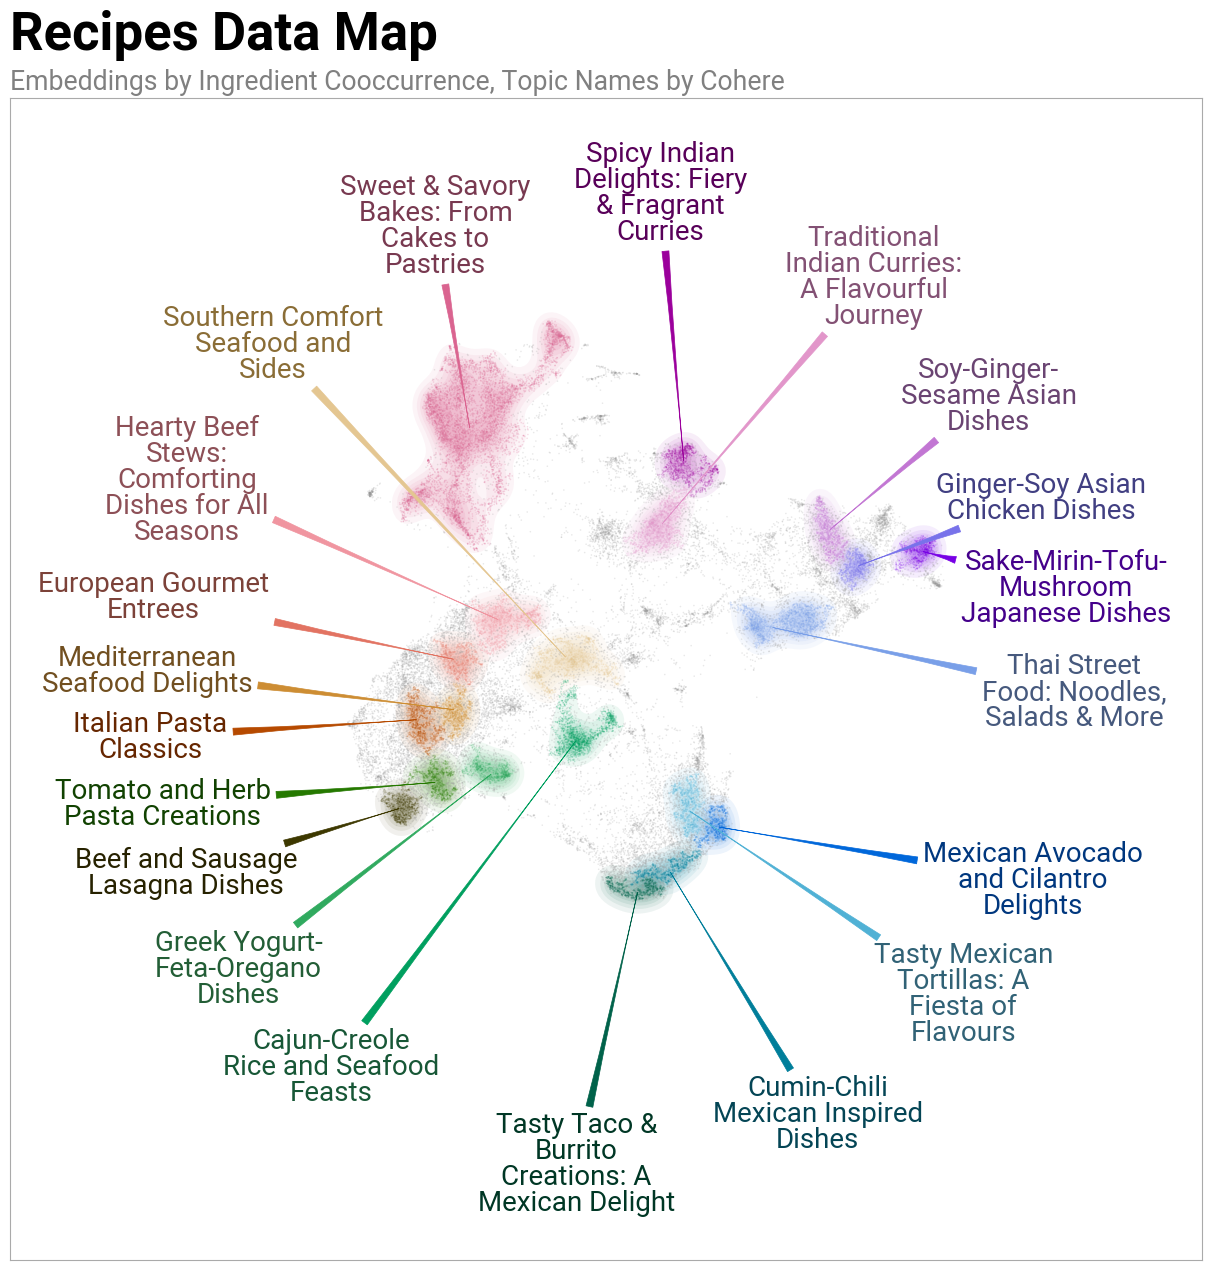

In [78]:
fig, ax = datamapplot.create_plot(
    df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    topic_namer.layer_clusters[0],
    title="Recipes Data Map",
    sub_title="Embeddings by Ingredient Cooccurrence, Topic Names by Cohere",
    label_font_size=20,
    use_medoids=True,
    color_label_arrows=True, 
    arrowprops={"arrowstyle": "wedge, tail_width=0.25, shrink_factor=0.25"},
)

In [59]:
all_labels = np.unique(df.loc[~df["is_ingredient"], "country"])
color_mapping = dict(
    zip(
        np.unique(all_labels),
        map(rgb2hex, sns.color_palette("tab20", len(all_labels)))
    )
)

In [60]:
custom_css="""
.row {
    display : flex;
    align-items : center;
}
.box {
    height:10px;
    width:10px;
    border-radius:2px;
    margin-right:5px;
    padding:0px 0 1px 0;
    text-align:center;
    color: white;
    font-size: 14px;
    cursor: pointer;
}
#legend {
    position: absolute;
    top: 0;
    right: 0;
}
#title-container {
    max-width: 75%;
}
"""

custom_html = """
<div id="legend" class="container-box">
"""
for field, color in color_mapping.items():
    custom_html += f'    <div class="row"><div id="{field}" class="box" style="background-color:{color};"></div>{field}</div>\n'
custom_html += """
</div>
"""

custom_js = """
const legend = document.getElementById("legend");
const selectedPrimaryFields = new Set();

legend.addEventListener('click', function(event) {
    const selectedField = event.srcElement.id;

    if (selectedField) {
        if (selectedPrimaryFields.has(selectedField)) {
            selectedPrimaryFields.delete(selectedField);
            event.srcElement.innerHTML = "";
        } else {
            selectedPrimaryFields.add(selectedField);
            event.srcElement.innerHTML = "✓";
        }
    }
    const selectedIndices = [];
    datamap.metaData.primary_field.forEach((field, i) => {
        if (selectedPrimaryFields.has(field)) {
            selectedIndices.push(i);
        }
    });
    datamap.addSelection(selectedIndices, "legend");
});
"""

hover_text_template = """
<div>
    <p>COUNTRY: {primary_field}</p>
    <p>INGREDIENTS: {hover_text}</p>
</div>
"""

In [61]:
extra_data = pd.DataFrame(
    {"primary_field": df.loc[~df["is_ingredient"], "country"]}
)

In [73]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["is_ingredient"], "country"],
    df.loc[~df["is_ingredient"], "region"],
    title="Recipes Data Map",
    sub_title="Embeddings by Ingredient Cooccurrence",
    inline_data=True,
    hover_text=df.loc[~df["is_ingredient"], "ingredients"].map(" , ".join),
    hover_text_html_template=hover_text_template,
    extra_point_data=extra_data,
    selection_handler=datamapplot.selection_handlers.WordCloud(100, width=500, height=300, n_rotations=0),
    use_medoids=True,
    enable_search=True,
)
# Change the word counter's behaviour to split on commas instead of whitespace.
plot._html_str = plot._html_str.replace("textItems.join(' ').toLowerCase().split(/\s+/);",
                                        "textItems.join(' ').toLowerCase().split(/,\s*/);")

In [74]:
plot

<InteractiveFigure width=100% height=800>

In [47]:
topic_names_col = df.columns[df.columns.str.startswith("topic_names_layer_")].sort_values()

In [71]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    *df.loc[~df["is_ingredient"], topic_names_col].values.T,
    use_medoids=True,
    title="Recipes Data Map",
    sub_title="Embeddings by Ingredient Cooccurrence, Topic Names by Cohere",
    # label_color_map=color_mapping,
    inline_data=True,
    hover_text=df.loc[~df["is_ingredient"], "ingredients"].map(", ".join),
    hover_text_html_template=hover_text_template,
    selection_handler=datamapplot.selection_handlers.WordCloud(100, width=500, height=300, n_rotations=0),
    cluster_boundary_polygons=True,
    extra_point_data=extra_data,
    enable_search=True,
    custom_css=custom_css,
    custom_html=custom_html,
    custom_js=custom_js,
)
# Change the word counter's behaviour to split on commas instead of whitespace.
plot._html_str = plot._html_str.replace("textItems.join(' ').toLowerCase().split(/\s+/);",
                                        "textItems.join(' ').toLowerCase().split(/,\s*/);")

In [72]:
plot

<InteractiveFigure width=100% height=800>

In [66]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["is_ingredient"], "country"],
    use_medoids=True,
    title="Recipes Data Map",
    sub_title="Embeddings by Ingredient Cooccurrence",
    label_color_map=color_mapping,
    inline_data=True,
    hover_text=df.loc[~df["is_ingredient"], "ingredients"].map(", ".join),
    hover_text_html_template=hover_text_template,
    selection_handler=datamapplot.selection_handlers.WordCloud(100, width=500, height=300, n_rotations=0),
    cluster_boundary_polygons=True,
    extra_point_data=extra_data,
    enable_search=True,
    custom_css=custom_css,
    custom_html=custom_html,
    custom_js=custom_js,
)
# Change the word counter's behaviour to split on commas instead of whitespace.
plot._html_str = plot._html_str.replace("textItems.join(' ').toLowerCase().split(/\s+/);",
                                        "textItems.join(' ').toLowerCase().split(/,\s*/);")

In [67]:
plot

<InteractiveFigure width=100% height=800>

In [14]:
plot.save(Path("../recipes_datamapplot.html"))